# Task 4 Modeling&Evaluation

Sub-Task 1:Build churn model(s) to try to predict the churn probability of any customer.

Sub-Task 2:Evaluate your model, using a holdout set, and with metrics of your choosing.

Sub-Task 3:Interpret the results and use them to formulate answers to the client’s hypotheses and questions. 

## Import packages

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(color_codes=True)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Load Data 

In [10]:
df=pd.read_csv("data_for_predictions (1).csv")   
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,1,0.00000,25.44,25.44,2,678.99,43.648,0.000061,2.627605e-05,0.000440,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,3,30,5,2,6,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,0,0.00000,16.38,16.38,1,18.89,13.800,0.000005,6.089453e-04,0.000000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,7,76,7,76,4,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,0,0.00000,28.60,28.60,1,6.60,13.856,0.000006,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,0,0.00000,30.22,30.22,1,25.46,13.200,0.000005,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,6,69,2,69,9,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,0,1.72689,44.91,44.91,1,47.98,19.800,0.000015,3.552481e-06,0.000003,0.005429,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.0558

## Splitting data 

In [ ]:
#First we need to specify features and target 
y=df['churn']
X=df.drop(['churn','id']7,axis=1)

In [12]:
#Check the binary target
y.value_counts()

churn
0    13187
1     1419
Name: count, dtype: int64

As we can see, the y(churn) is imbalanced

In [13]:
#Spliting dataset 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

## Base Models

We are going to quickly test the fit of 6 different models 
* Logistic Regression: basic linear classifier (good to baseline)
* Random Forest: ensemble bagging classifier
* K-Nearest Neighbors: instance based classifier
* Support Vector Machines: maximum margin classifier
* Gaussian Naive Bayes: probabilistic classifier
* XGBoost: ensemble (extreme!) boosting classifier

In [14]:
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB 
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs=[]
    models =[('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier ()),
        ('KNN', KNeighborsClassifier ()),
        ('SVM', SVC()), 
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier(eval_metric='mlogloss'))
            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['not churn', 'churn']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final

In [15]:
run_exps(X_train,y_train,X_test,y_test)

LogReg
              precision    recall  f1-score   support

   not churn       0.91      1.00      0.95      2645
       churn       0.00      0.00      0.00       277

    accuracy                           0.91      2922
   macro avg       0.45      0.50      0.48      2922
weighted avg       0.82      0.91      0.86      2922

RF
              precision    recall  f1-score   support

   not churn       0.91      1.00      0.95      2645
       churn       0.90      0.06      0.12       277

    accuracy                           0.91      2922
   macro avg       0.91      0.53      0.54      2922
weighted avg       0.91      0.91      0.87      2922

KNN
              precision    recall  f1-score   support

   not churn       0.91      0.99      0.95      2645
       churn       0.08      0.01      0.01       277

    accuracy                           0.90      2922
   macro avg       0.49      0.50      0.48      2922
weighted avg       0.83      0.90      0.86      2922

SVM
 

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.090356,0.010483,0.906290,0.868532,0.906290,0.862567,0.596697,LogReg
1,0.079908,0.005514,0.896876,0.807304,0.896876,0.849736,0.645186,LogReg
2,0.079962,0.009124,0.909285,0.872795,0.909285,0.867724,0.598016,LogReg
3,0.076057,0.010854,0.894309,0.799788,0.894309,0.844412,0.611601,LogReg
4,0.075921,0.006264,0.902825,0.815094,0.902825,0.856719,0.598392,LogReg
5,2.294712,0.074193,0.909285,0.891575,0.909285,0.872527,0.665977,RF
6,2.377010,0.066676,0.901583,0.900340,0.901583,0.858509,0.685371,RF
7,2.393186,0.064777,0.911853,0.892907,0.911853,0.875908,0.665413,RF
8,2.334911,0.064227,0.897732,0.891223,0.897732,0.854058,0.649874,RF
9,2.247950,0.049882,0.906250,0.905667,0.906250,0.865624,0.677896,RF


In [16]:
final=run_exps(X_train,y_train,X_test,y_test)
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model==model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

LogReg
              precision    recall  f1-score   support

   not churn       0.91      1.00      0.95      2645
       churn       0.00      0.00      0.00       277

    accuracy                           0.91      2922
   macro avg       0.45      0.50      0.48      2922
weighted avg       0.82      0.91      0.86      2922

RF
              precision    recall  f1-score   support

   not churn       0.91      1.00      0.95      2645
       churn       0.88      0.05      0.10       277

    accuracy                           0.91      2922
   macro avg       0.90      0.53      0.53      2922
weighted avg       0.91      0.91      0.87      2922

KNN
              precision    recall  f1-score   support

   not churn       0.91      0.99      0.95      2645
       churn       0.08      0.01      0.01       277

    accuracy                           0.90      2922
   macro avg       0.49      0.50      0.48      2922
weighted avg       0.83      0.90      0.86      2922

SVM
 

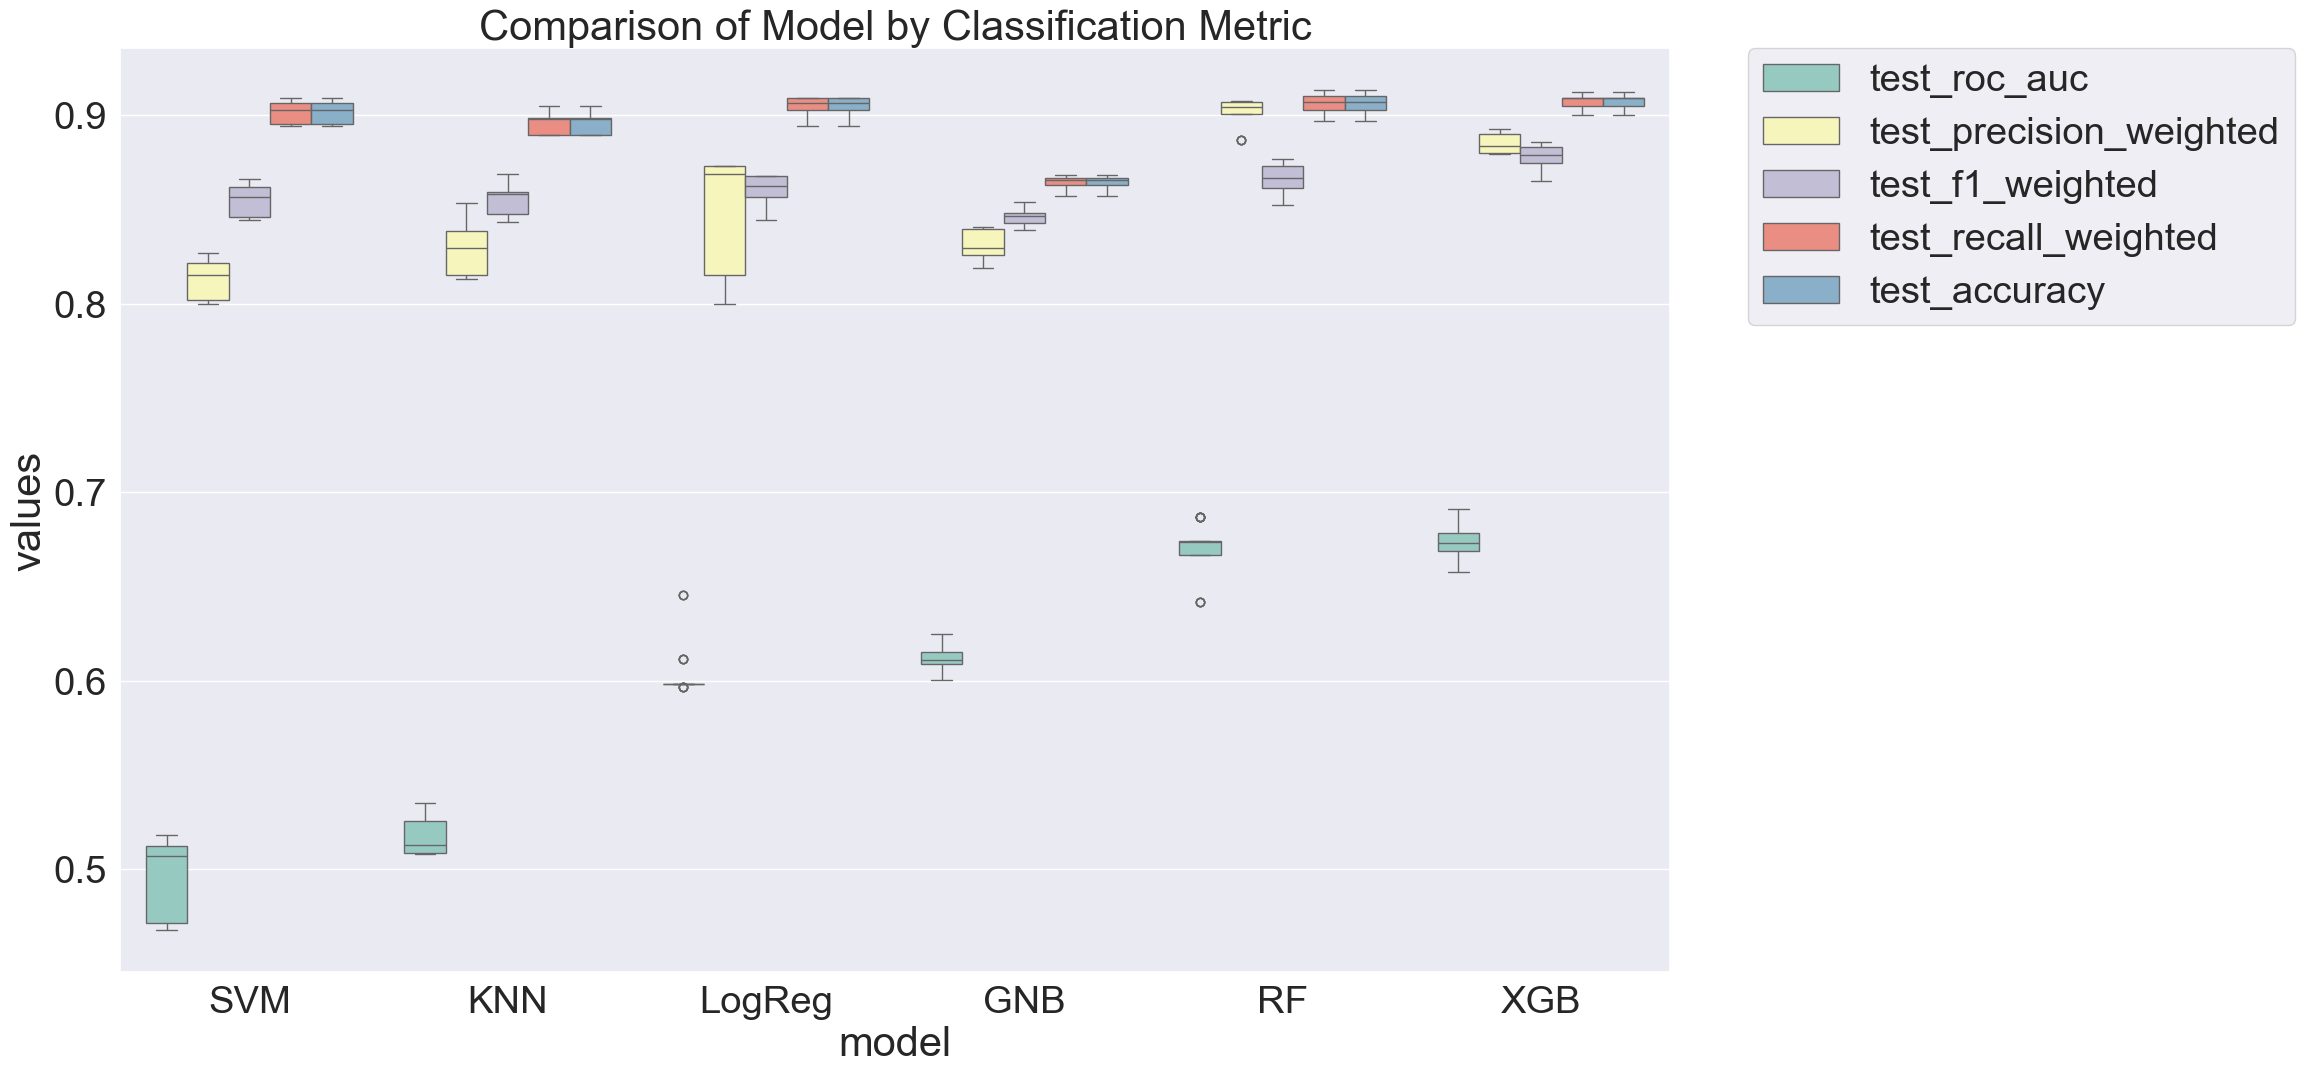

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

It is clearly that GNBs fit our data poorly across alomast all the metrics, and the XGBoost and Random Forest fit the data very well

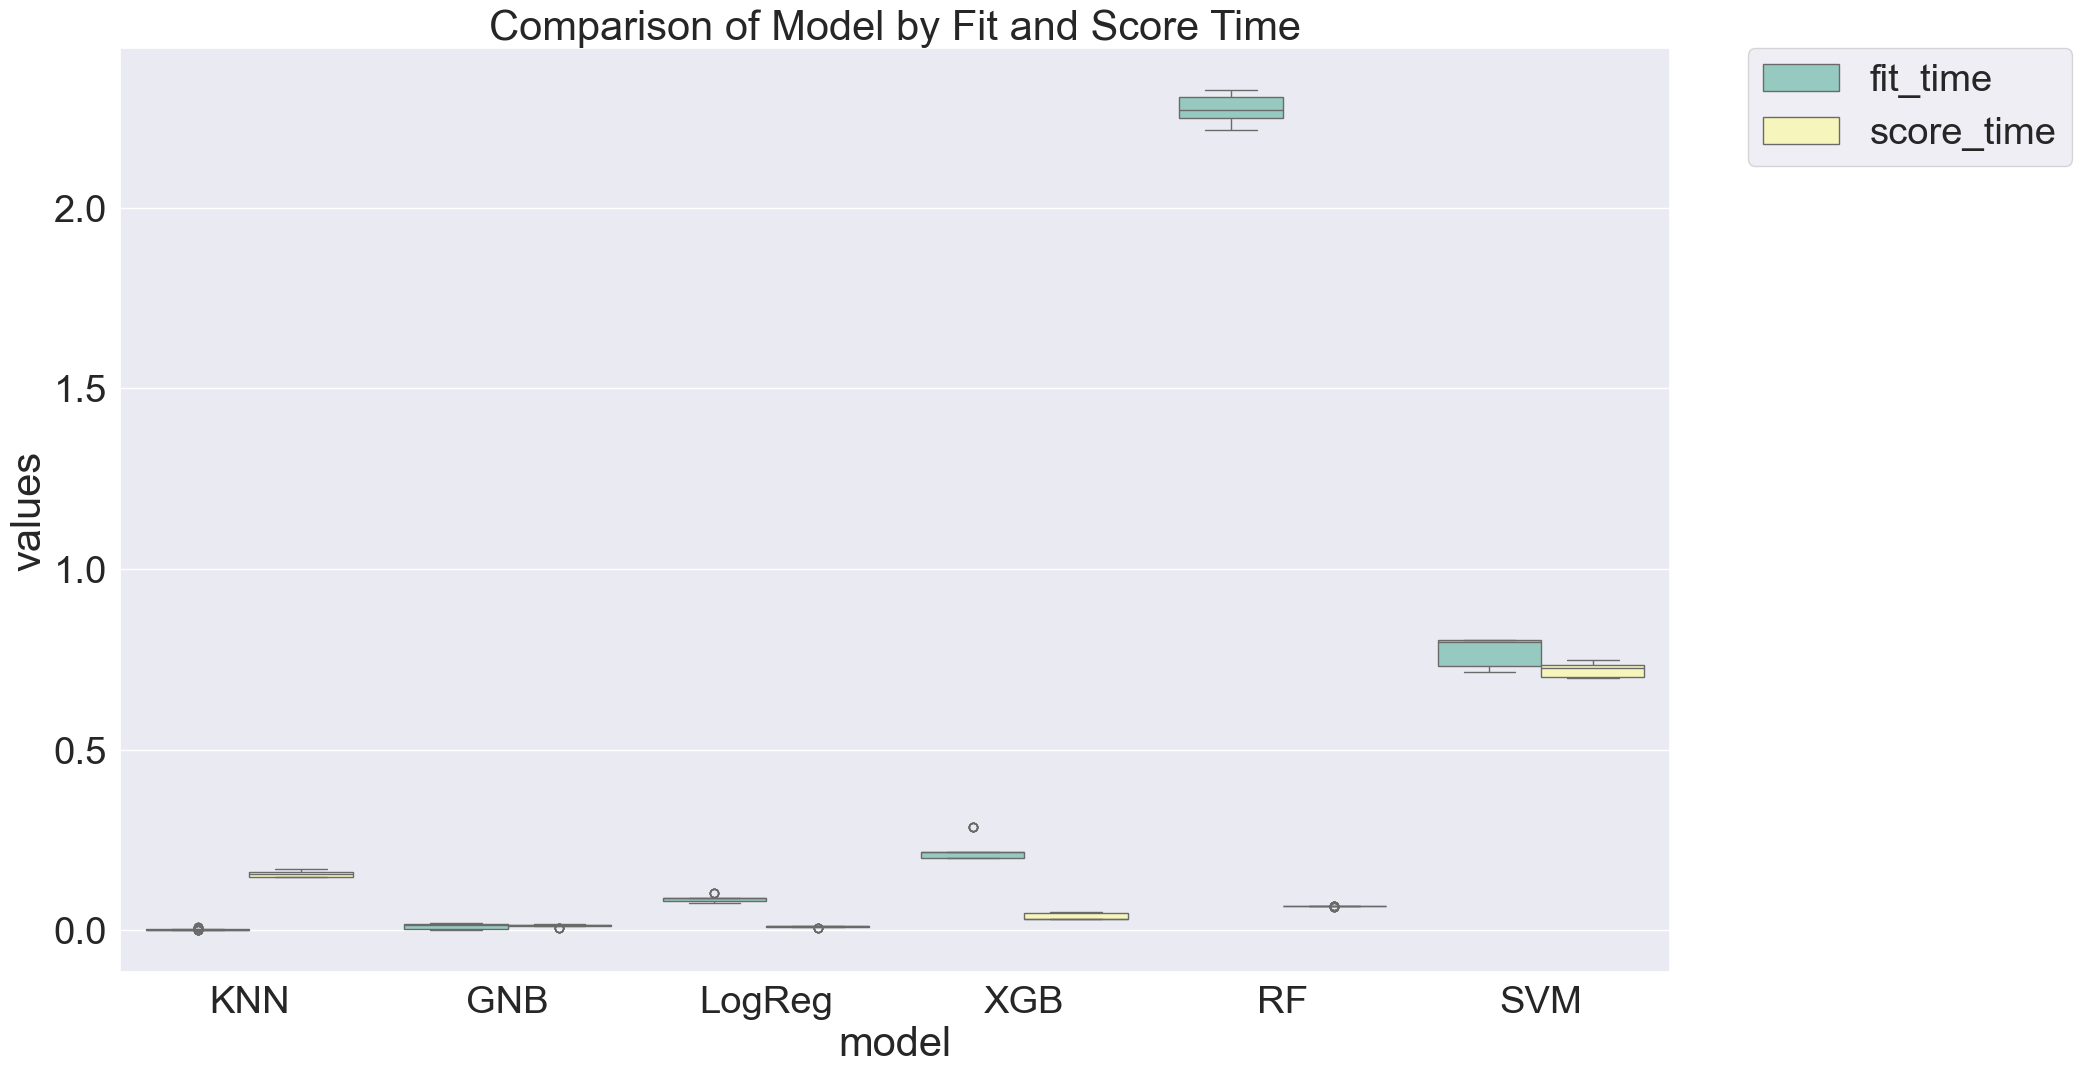

In [18]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

From the figure above we can see that the SVM is slow to train and score,for the Random Forest and XGBoost, the XGBoost has faster fit time

In [19]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_roc_auc           test_accuracy           test_precision_weighted  \
                std      mean           std      mean                     std   
model                                                                           
GNB        0.007891  0.611298      0.004143  0.863790                0.008757   
KNN        0.009385  0.517136      0.005159  0.895540                0.012664   
LogReg     0.014622  0.604400      0.005557  0.904256                0.032072   
RF         0.013602  0.671002      0.005123  0.906251                0.006643   
SVM        0.020369  0.495942      0.005460  0.901387                0.009844   
XGB        0.011135  0.674567      0.004061  0.906924                0.005157   

                 test_recall_weighted           test_f1_weighted            
            mean                  std      mean              std      mean  
model                                                                       
GNB     0.831051             0.004143  0.863790         0.005130  0.845857  
KNN     0.828416             0.005159  0.895540         0.007620  0.855010  
LogReg  0.844261             0.005557  0.904256         0.008509  0.859757  
RF      0.902416             0.005123  0.906251         0.007838  0.866430  
SVM     0.812527             0.005460  0.901387         0.007900  0.854646  
XGB     0.884682             0.004061  0.906924         0.006950  0.877731

In [20]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

score_time            fit_time          
              std      mean       std      mean
model                                          
GNB      0.004142  0.012183  0.007380  0.012020
KNN      0.008316  0.156428  0.002345  0.002642
LogReg   0.001790  0.009876  0.008495  0.086754
RF       0.001235  0.066779  0.037460  2.268514
SVM      0.017125  0.720633  0.037462  0.775780
XGB      0.009247  0.038757  0.032119  0.223990

Based on the analysis of six models, I will focus on the XGBoost as continue  refining model, not only because it has the best performing but also it has relativily fast train and score time

## Model Finetuning

In [21]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [22]:
#Create the random grid
params={
    'min_child_weight':[i for i in np.arange(1,15,1)],
    'gamma':[i for i in np.arange(0,6,0.5)],
    'subsample':[i for i in np.arange(0,1.1,0.1)],
    'colsample_bytree':[i for i in np.arange(0,1.1,0.1)],
    'max_depth':[i for i in np.arange(1,15,1)],
    'scale_pos_weight':[i for i in np.arange(0,0.15,0.01)],
    'learning_rate':[i for i in np.arange(0,0.15,0.01)],
    'n_estimators':[i for i in np.arange(0,2000,100)],
}

In [23]:
#Create model 
xg=xgb.XGBClassifier(objective='binary:logistic',nthread=1,eval_metric='mlogloss')

In [24]:
#Random search of parameters,using 5
xg_random=RandomizedSearchCV(xg,param_distributions=params,
                            n_iter=1,scoring='roc_auc',
                            n_jobs=4,cv=5,verbose=3,random_state=1001)
xg_random.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                        'n_estimators': [0, 100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900],
                                        'scale_pos_weight': [0.0, 0.01, 0.02,
                                                             0.03, 0.04, 0.05,
                                                             0.06, 0.07, 0.08,
                                                             0.09, 0.1, 0.11,
                                                             0.12, 0.13, 0.14],
                                        'subsample': [0.0, 0.1, 0.2,
                                                      0.30000000000000004, 0.4,
                                                      0.5, 0.6000000000000001,
                                                      0.7000000000000001, 0.8,
                                                      0.9, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [25]:
best_random=xg_random.best_params_
best_random={'subsample':0.8,
'scale_pos_weight':1,
'n_estimators':1100,
'max_depth':12,
'learning_rate':0.01,
'gamma':4.0,
'colsample_bytree':0.60}

In [26]:
#Create a model with the parameters found
model_random=xgb.XGBClassifier(objective='binary:logistic',
                               nthread=1,eval_metric='mlogloss',**best_random)
                              
fprs,tprs,score=[],[],[]

In [27]:
from sklearn.model_selection import StratifiedKFold
cv=StratifiedKFold(n_splits=5,random_state=13,shuffle=True)

In [28]:
from sklearn import metrics
def compute_roc_auc(model_,index):
    y_predict=model_.predict_proba(X.iloc[index])[:,1]
    fpr,tpr,threholds=metrics.roc_curve(y.iloc[index],y_predict)
    auc_score=metrics.auc(fpr,tpr)
    return fpr,tpr,auc_score

In [29]:
for (train,test), i in zip(cv.split(X,y),range(5)):
    model_random.fit(X.iloc[train],y.iloc[train])
    _,_,auc_score_train=compute_roc_auc(model_random,train)
    fpr,tpr,auc_score=compute_roc_auc(model_random,test)
    score.append((auc_score_train,auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

In [30]:
def plot_roc_curve(fprs,tprs):
    tprs_interp=[]
    aucs=[]
    mean_fpr=np.linspace(0,1,100)
    f,ax=plt.subplots(figsize=(18,10))
    
    for i,(fpr,tpr) in enumerate(zip(fprs,tprs)):
        tprs_interp.append(np.interp(mean_fpr,fpr,tpr))
        tprs_interp[-1][0]=0.0
        roc_auc=metrics.auc(fpr,tpr)
        aucs.append(roc_auc)
        ax.plot(fpr,tpr,lw=2,alpha=0.3,
                label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc))
    plt.plot([0,1],[0,1],linestyle='--',lw=3,color='r',label="Rondom",alpha=.8)
    mean_tpr=np.mean(tprs_interp,axis=0)
    mean_tpr[-1]=1.0
    mean_auc=metrics.auc(mean_fpr,mean_tpr)
    std_auc=np.std(aucs)
    ax.plot(mean_fpr,mean_tpr,color='b',
            label=r"Mean ROC (AUC= %0.2f $\pm$ %0.2f)" % (mean_auc,std_auc),
           lw=4,alpha=.8)
    std_tpr=np.std(tprs_interp,axis=0)
    tprs_upper=np.minimum(mean_tpr+std_tpr,1)
    tprs_lower=np.maximum(mean_tpr-std_tpr,0)
    
    ax.fill_between(mean_fpr,tprs_lower,tprs_upper,color='grey',
                   label=r'$\pm$ 1 std. dev.',alpha=.2)
    ax.set_xlim([-0.05,1.05])
    ax.set_ylim([-0.05,1.05])
    ax.set_xlabel('False Positive Rate(FPR)')
    ax.set_ylabel('True Positive Rate(TPR)')
    ax.set_title('ROC-AUC')
    ax.legend(loc='lower right')
    plt.show()
    return (f, ax)

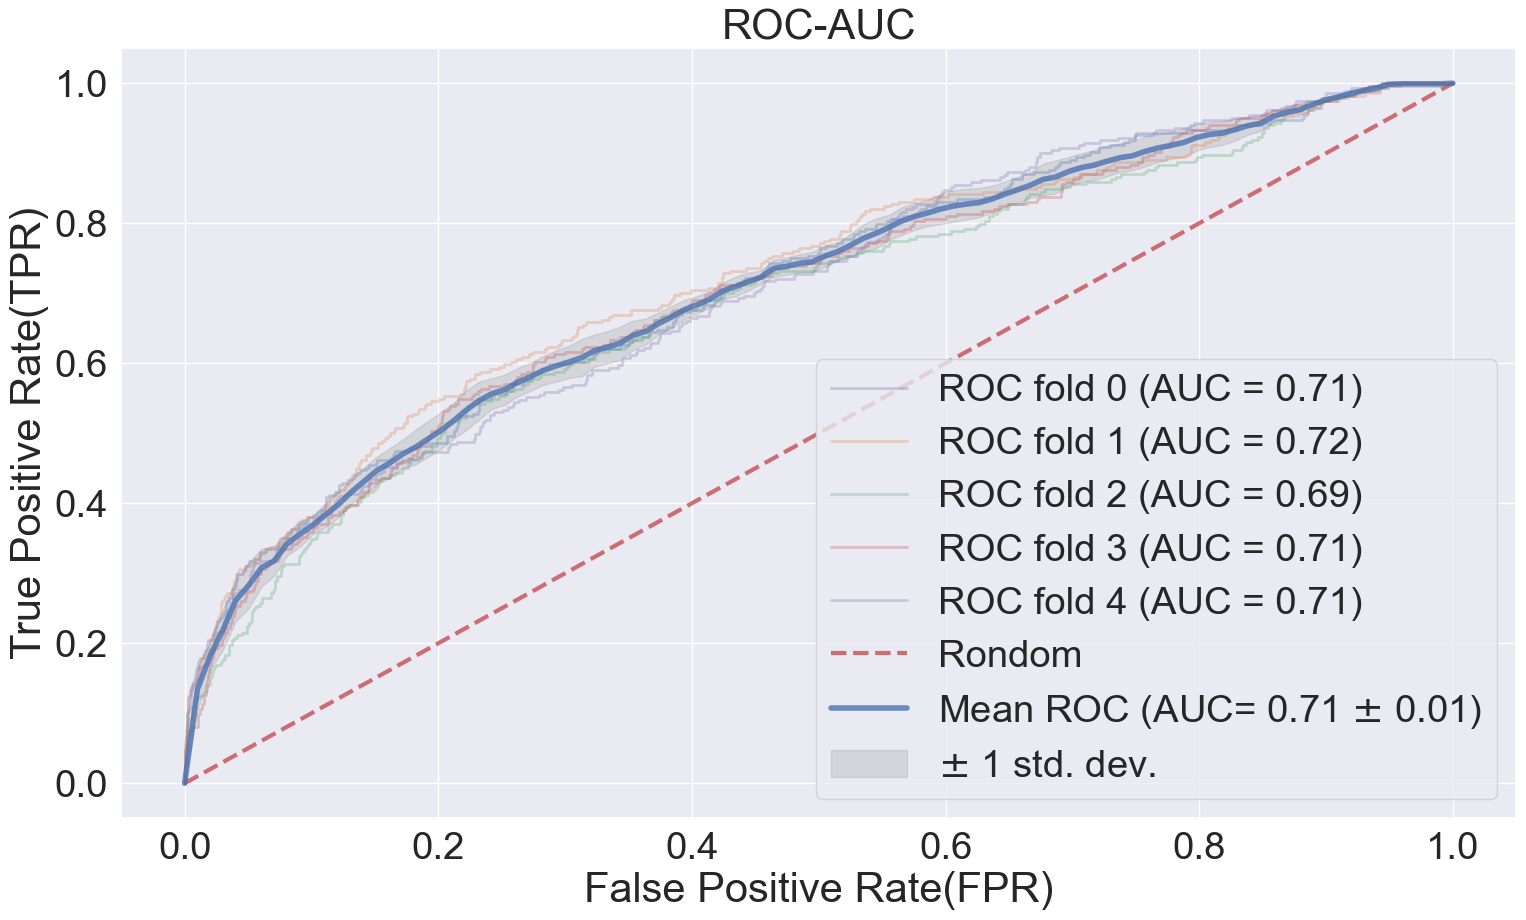

In [31]:
plot_roc_curve(fprs,tprs)
plt.show()

### Grid search with cross validation

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
param_grid={'subsample':[0.7],
'scale_pos_weight':[1],
'n_estimators':[1100],
'min_child_weight':[1],
'max_depth':[12,13,14],
'learning_rate':[0.005,0.01],
'gamma':[4.0],
'colsample_bytree':[0.6]}

In [34]:
xg=xgb.XGBClassifier(objective='binary:logistic',eval_metric='mlogloss')

In [35]:
grid_search=GridSearchCV(estimator=xg,param_grid=param_grid,
                            cv=5,n_jobs= -1,verbose=2,scoring='roc_auc')
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6], 'gamma': [4.0],
                         'learning_rate': [0.005, 0.01],
                         'max_depth': [12, 13, 14], 'min_child_weight': [1],
                         'n_estimators': [1100], 'scale_pos_weight': [1],
                         'subsample': [0.7]},
             scoring='roc_auc', verbose=2)

In [36]:
best_grid=grid_search.best_params_
best_grid

{'colsample_bytree': 0.6,
 'gamma': 4.0,
 'learning_rate': 0.005,
 'max_depth': 13,
 'min_child_weight': 1,
 'n_estimators': 1100,
 'scale_pos_weight': 1,
 'subsample': 0.7}

In [37]:
model_grid=xgb.XGBClassifier(objective='binary:logistic',
                            nthread=1,eval_metric='mlogloss',**best_grid)
                              
fprs,tprs,score=[],[],[]

In [38]:
for (train,test), i in zip(cv.split(X,y),range(5)):
    model_grid.fit(X.iloc[train],y.iloc[train])
    _,_,auc_score_train=compute_roc_auc(model_grid,train)
    fpr,tpr,auc_score=compute_roc_auc(model_grid,test)
    score.append((auc_score_train,auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

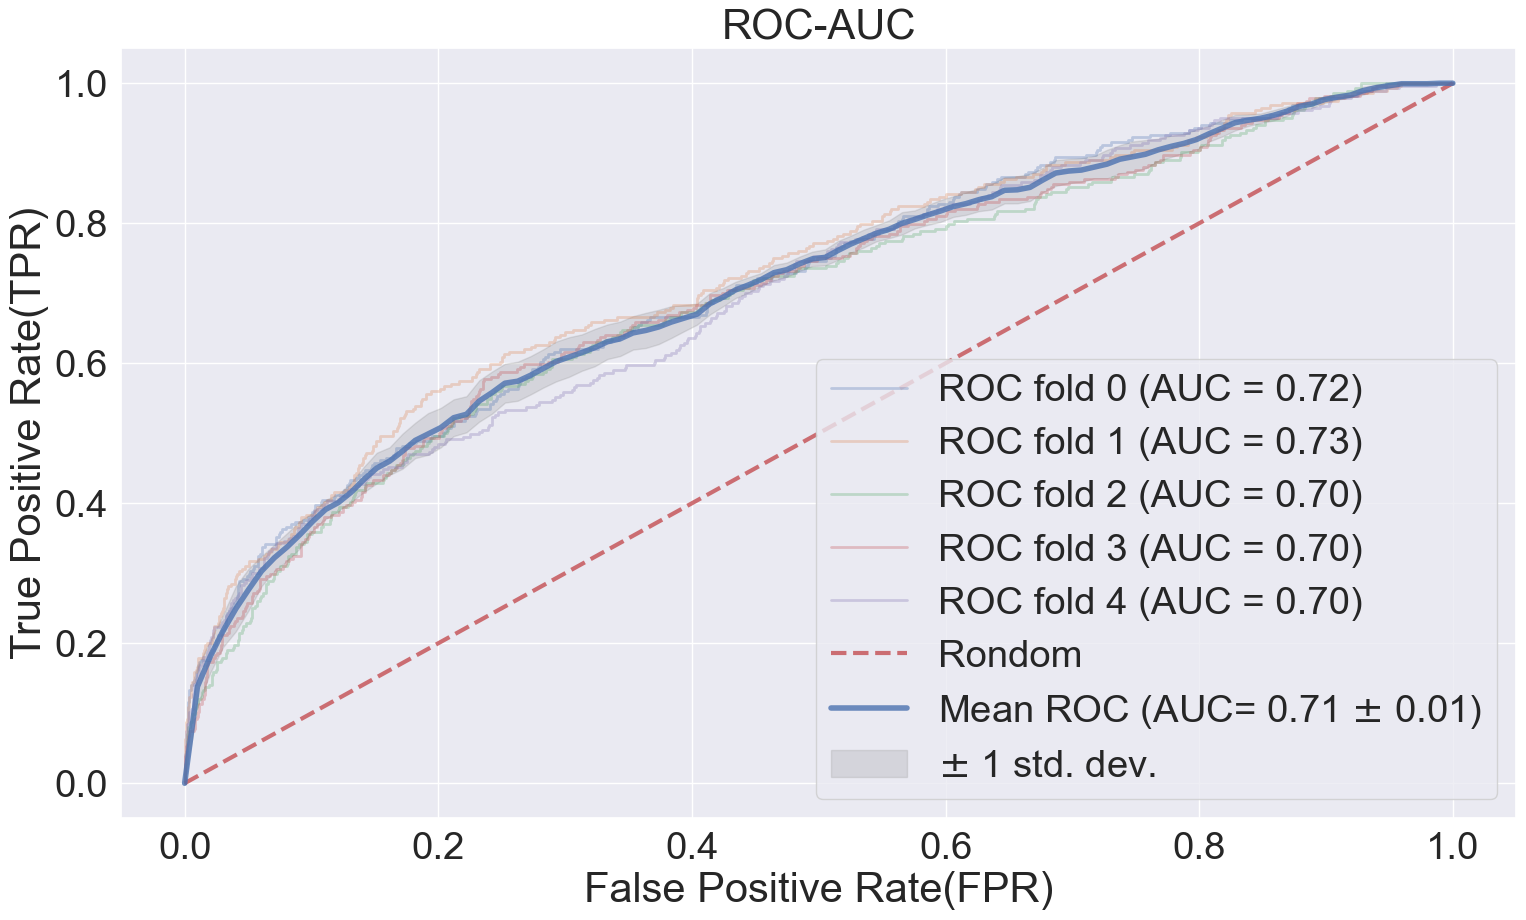

In [39]:
plot_roc_curve(fprs,tprs)
plt.show()

## Understanding the model

### Feature importance

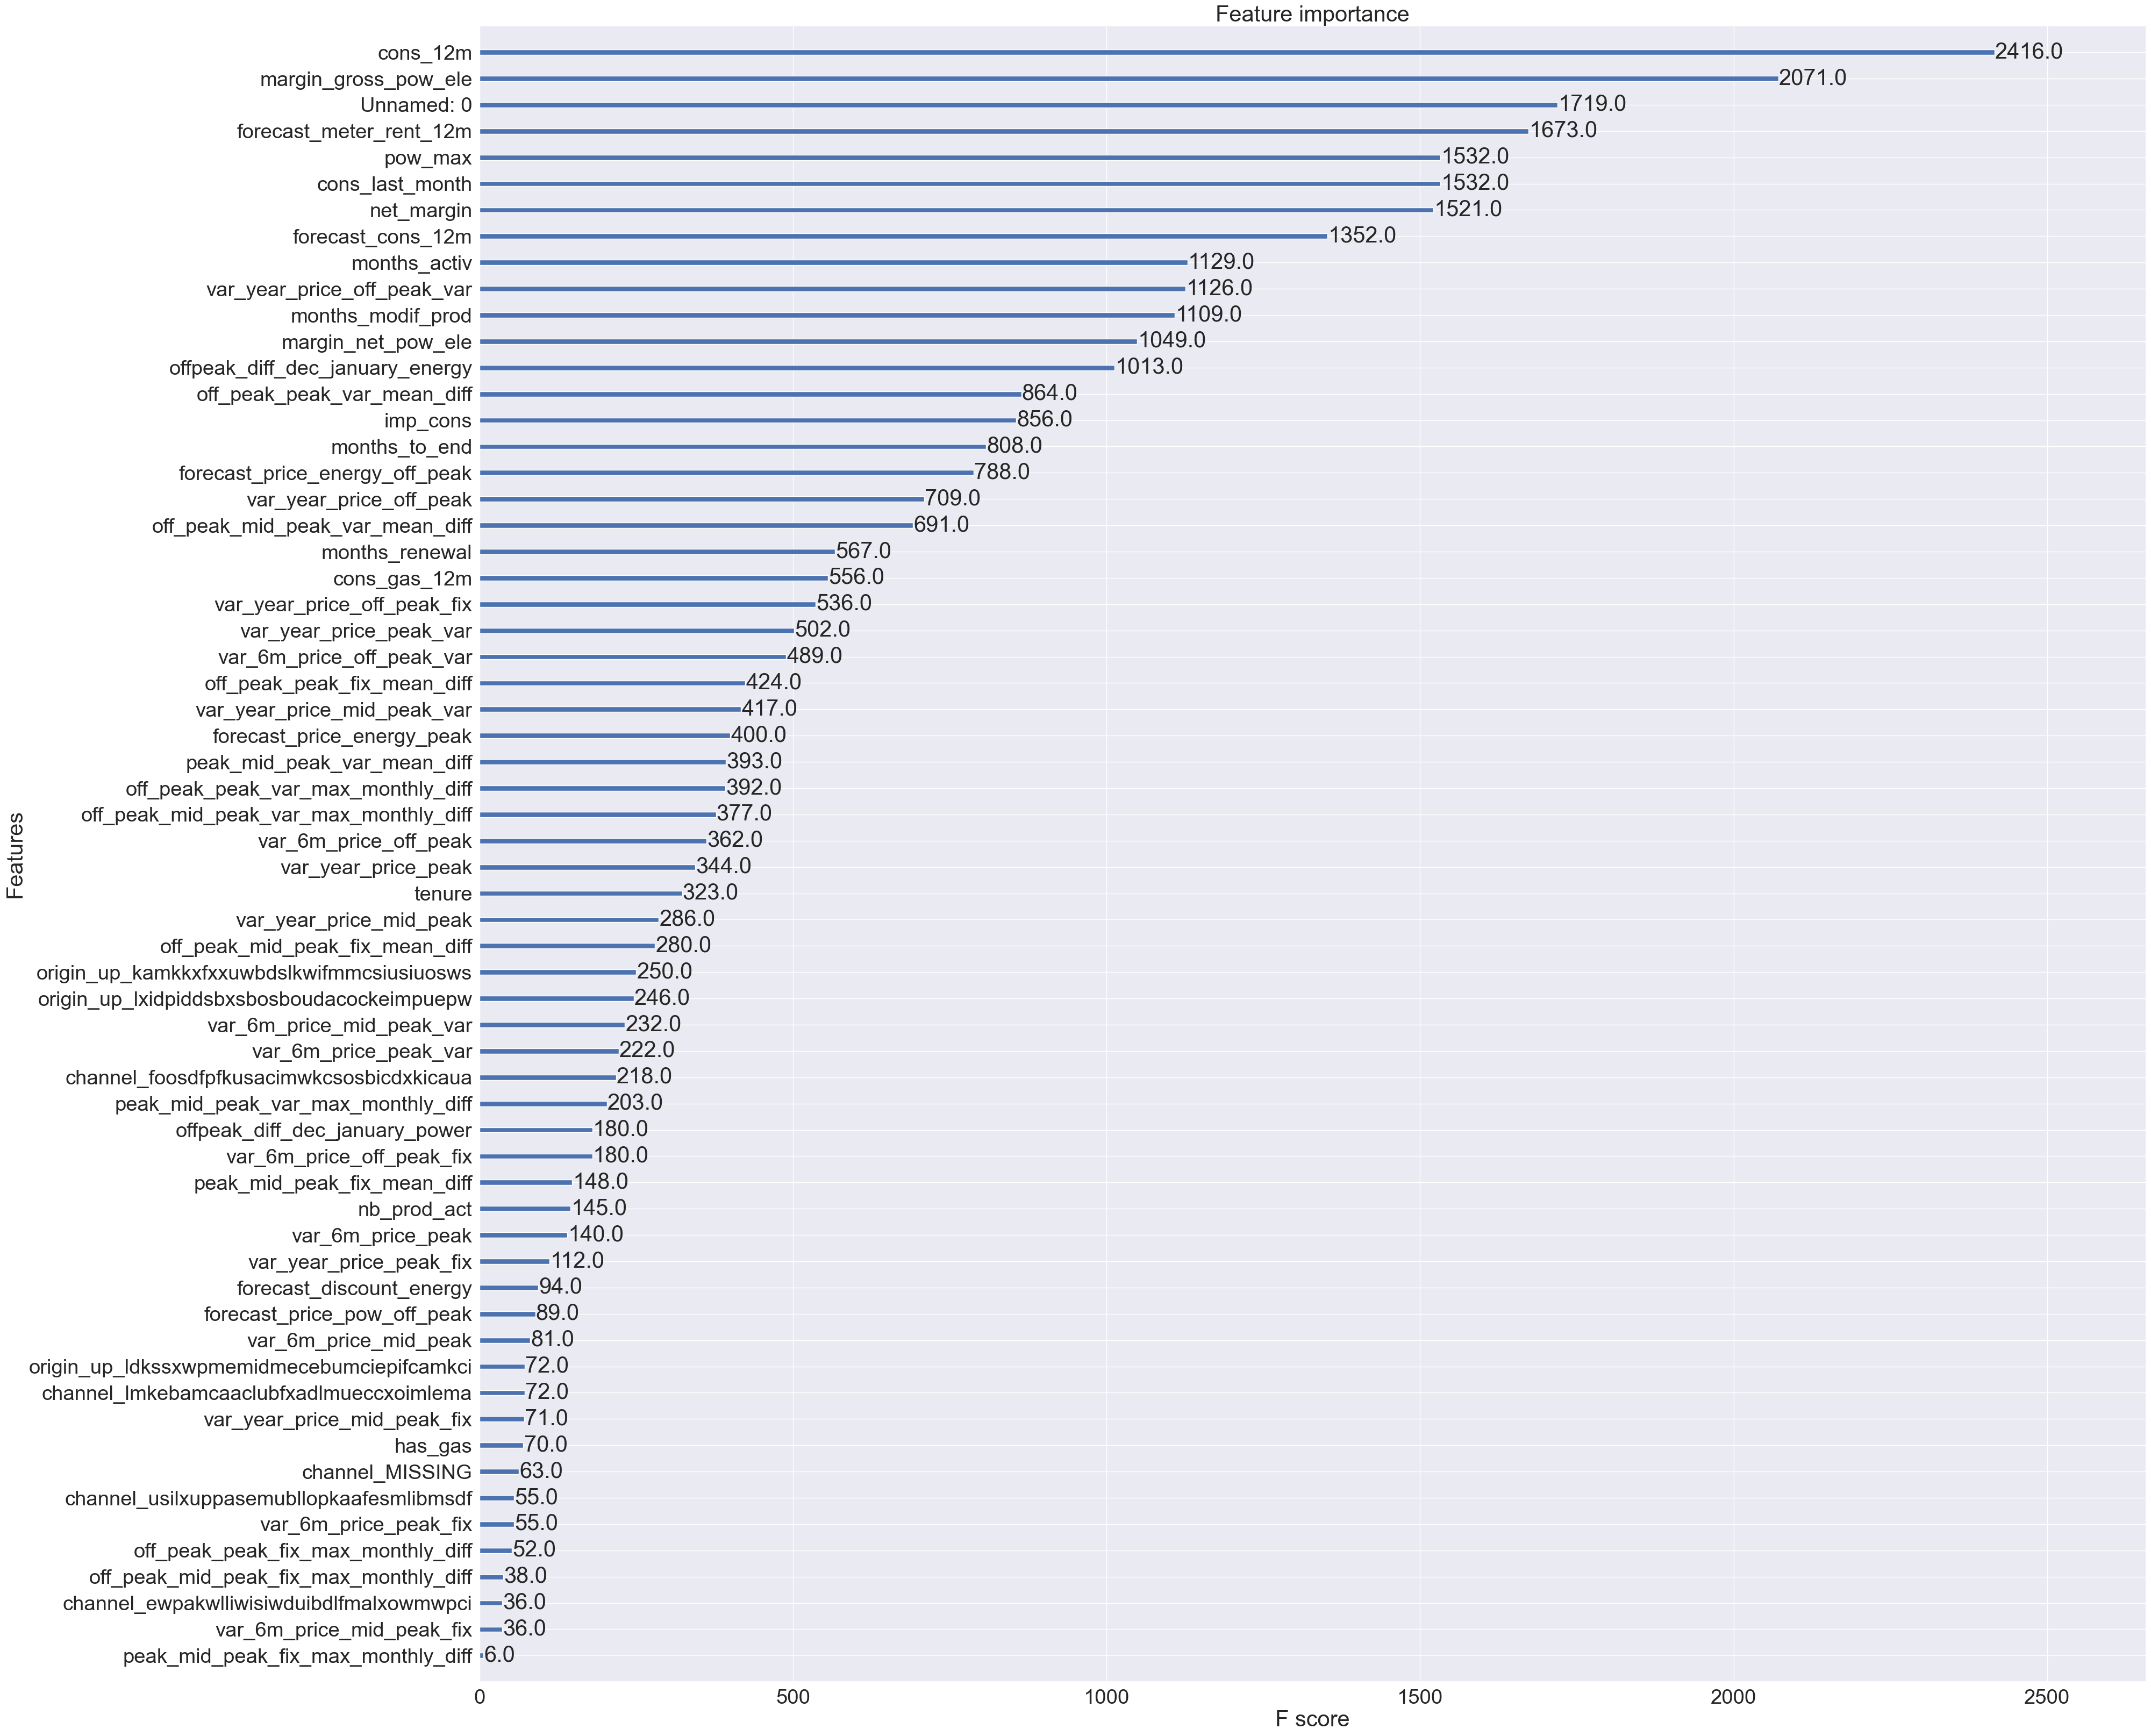

In [40]:
fig,ax=plt.subplots()
fig.set_size_inches(40, 40)
xgb.plot_importance(model_grid,ax=ax);

### Partial dependence plot 

In [46]:
from sklearn.inspection import PartialDependenceDisplay


In [47]:
model_grid_v2=xgb.XGBClassifier(objective='binary:logistic',
                               eval_metric='mlogloss',nthread=1,**best_grid)
model_grid_v2.fit(X_train.values,y_train.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=4.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1100,
              n_jobs=None, nthread=1, num_parallel_tree=None, ...)

<Figure size 1500x1500 with 0 Axes>

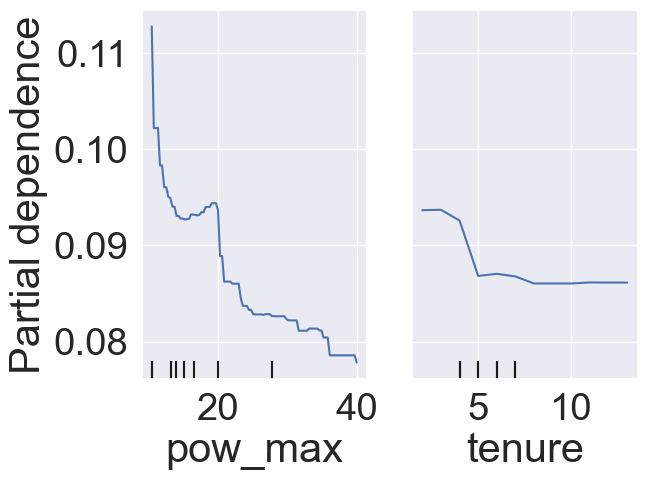

In [50]:
plt.figure(figsize=(15, 15))

# Use PartialDependenceDisplay.from_estimator to create the plot
PartialDependenceDisplay.from_estimator(
    estimator=model_grid_v2, 
    X=X_test, 
    features=[16, 49],  # specify the feature indices you want to plot
    feature_names=X_test.columns.tolist()
)

plt.show()